First, create a new conda environment named BI2025 and install the required packages from requirements.txt


In [1]:
#!conda create -n BI2025 python=3.11 -y
#!conda activate BI2025
#!pip install -r requirements.txt

In [2]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import typing
import requests
import time
import shutil
import json
from starvers.starvers import TripleStoreEngine

## Graph-based documentation preliminaries

**!!!IMPORTANT!!!**

Everytime you work on this notebook, enter your student ID in the `executed_by` variable so that the cell executions are accredited to you.

In [3]:
executed_by ='stud-id_12017130'  # Replace the digits after "id_" with your own student ID

Set your group and student IDs. Do this only once.

In [4]:
# group id for this project
group_id = '54'  # Replace the digits with your group id

# Students working on this notebook
student_a = 'stud-id_12017130'  # Replace the digits after "id_" with student A's student ID
student_b = 'stud-id_12122531'  # Replace the digits after "id_" with student B's student ID

In [5]:
# Roles. Don't change these values.
code_writer_role = 'code_writer'
code_executor_role = 'code_executor'

Setup the starvers API for logging your steps into our server-sided graph database.

In [6]:
get_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025"
post_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025/statements"
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)

Use these prefixes in your notebooks. You can extend this dict with your prefixes of additional ontologies that you use in this notebook. Replace 00 with your group id

In [7]:
prefixes = {
    'xsd': 'http://www.w3.org/2001/XMLSchema#',
    'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'prov': 'http://www.w3.org/ns/prov#',
    'sc': 'https://schema.org/',
    'cr': 'http://mlcommons.org/croissant/',
    'mls': 'http://www.w3.org/ns/mls#',
    'mlso': 'http://w3id.org/mlso',
    'siu': 'https://si-digital-framework.org/SI/units/',
    'siq': 'https://si-digital-framework.org/SI/quantities/',
    'qudt': 'http://qudt.org/schema/qudt/',
    '': f'https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/',
}

prefix_header = '\n'.join([f'PREFIX {k}: <{v}>' for k, v in prefixes.items()]) + '\n\n'

Ontologies to use
* Provenance of the experiment process
    * PROV-O: 
        * doc: https://www.w3.org/TR/prov-o/
        * serialization: https://www.w3.org/ns/prov-o
* Data used and created
    * schema.org - Dataset: 
        * doc: https://schema.org/Dataset
        * serialization: https://schema.org/version/latest/schemaorg-current-https.ttl
    * Crossaint
        * doc: https://docs.mlcommons.org/croissant/docs/croissant-spec.html
        * serialization: https://github.com/mlcommons/croissant/blob/main/docs/croissant.ttl
* ML experiments performed
    * MLSO: 
        * doc: https://github.com/dtai-kg/MLSO
        * doc: https://dtai-kg.github.io/MLSO/#http://w3id.org/
        * serialization: https://dtai-kg.github.io/MLSO/ontology.ttl
* Measurements, Metrics, Units
    * QUDT
        * doc:https://qudt.org/
        * doc: https://github.com/qudt/qudt-public-repo
        * serialization: https://github.com/qudt/qudt-public-repo/blob/main/src/main/rdf/schema/SCHEMA_QUDT.ttl
    * SI Digital Framework
        * doc: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/docs/README.md
        * doc: https://si-digital-framework.org/
        * doc: https://si-digital-framework.org/SI
        * serialization: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/TTL/si.ttl
    * Quantities and Units
        * doc: https://www.omg.org/spec/Commons
        * serialization: https://www.omg.org/spec/Commons/QuantitiesAndUnits.ttl

Use this function to record execution times.

In [11]:
def now() -> str:
    """
    Returns the current time in ISO 8601 format with UTC timezone in the following format:
    YYYY-MM-DDTHH:MM:SS.sssZ
    """
    timestamp = datetime.datetime.now(datetime.timezone.utc)
    timestamp_formated = timestamp.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]  +"Z"

    return timestamp_formated

Register yourself in the Knowledge Graph using ProvO. Change the given name, family name and immatriculation number to reflect your own data.

In [12]:
# Ontologies used: foaf, prov, IAO
reigstration_triples_a = [
f':{student_a} rdf:type foaf:Person .',
f':{student_a} rdf:type prov:Agent .',
f':{student_a} foaf:givenName "Alexander" .',
f':{student_a} foaf:familyName "Resch" .',
f':{student_a} <http://vivoweb.org/ontology/core#identifier> :{student_a} .',
f':{student_a} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_a} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_a} <http://purl.obolibrary.org/obo/IAO_0000219> "12017130"^^xsd:string .',
]

reigstration_triples_b = [
f':{student_b} rdf:type foaf:Person .',
f':{student_b} rdf:type prov:Agent .',
f':{student_b} foaf:givenName "Jakob" .',
f':{student_b} foaf:familyName "Kimeswenger" .',
f':{student_b} <http://vivoweb.org/ontology/core#identifier> :{student_b} .',
f':{student_b} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_b} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_b} <http://purl.obolibrary.org/obo/IAO_0000219> "12122531"^^xsd:string .',
]

role_triples = [
    f':{code_writer_role} rdf:type prov:Role .',
    f':{code_executor_role} rdf:type prov:Role .',
]


engine.insert(reigstration_triples_a, prefixes=prefixes)
engine.insert(reigstration_triples_b, prefixes=prefixes)
engine.insert(role_triples, prefixes=prefixes)

**What not do do**

Do not use [blank nodes](https://www.w3.org/wiki/BlankNodes).

PROV-O uses blank nodes to connect multiple elements with each other.
Such blank nodes (such as _:association) should not be used.
Instead, assign a fixed node ID such as
:5119fcd7-b571-41e0-9464-a37c7be0f574 by generating them outside of the
notebook.
We suggest that, for each setting where such a blank node is needed to
connect multiple elements, you create a unique hash (using uuid.uuid4())
and keep this as hard-coded identifier for the blank node. The template
notebook contains examples of this. Do *not* use these provided values,
as otherwise, your provenance documentations will all be connected via
these identifiers!
Also, do not generate them dynamically in every cell execution, e.g. by
using uuid.uuid4() in a cell. This would generate many new linking nodes
for connecting the same elements.
Compute one for each node (cell) where you need them and make sure to
use the same one on each re-execution of the notebook.

In [13]:
weather_data_path = os.path.join("data", "datasets", "weather")
cyclists_data_path = os.path.join("data", "datasets", "cyclists")

## Business Understanding 

In [14]:
## Each Activity that follows is part of the Business Understanding Phase

business_understanding_phase_executor = [
f':business_understanding_phase rdf:type prov:Activity .',
f':business_understanding_phase rdfs:label "Business Understanding Phase" .', ## Phase 1: Business Understanding
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [15]:
#############################################
# Documentation
#############################################

data_src_and_scenario_comment = """
We decided to use the "Corporate Credit Rating with Financial Ratios" dataset available on Kaggle.
The dataset contains a set of financial ratios measuring liquidity, leverage and profitability for multiple companies, together with a corporate credit rating label.
The scenario is a financial institution that wants to assess corporate credit risk based on financial statement information.
The model should assist analysts in assigning credit ratings in decision on creditworthiness.
"""

business_objectives_comment = """
-) Support analysts with consistent credit rating decisions for coporate clients.
-) Identify companies with high credit risk early, to reduce credit losses.
-) Decrease the effort for manual review for low risk companies.
-) At new credit applications, speed up the rating decisions.
"""

business_success_criteria_comment = """
-) Reduce inconsistencies in ratings between analysts by 15 percent.
-) Cut down average review time by 20 percent per company.
-) Keep the share of wrongly accepted high-risk firms below 10 percent.
-) Avoid blocking of more than 30 percent of low-risk firms.
"""

data_mining_goals_comment = """
-) Train a multi-class classifier that predicts corporate credit ratings from financial ratios.
-) Provide calibrated probability scores to rank firms by risk.
-) Identify the most important financial ratios driving the rating decisions.
-) Support later analysis of class-wise performance for different rating levels.
"""

data_mining_success_criteria_comment = """
-) Achieve a macro-averaged F1 score of at least 0.7 on the test set.
-) Achieve at least a recall of 0.75 for the lowest rating classes.
-) Keep the difference between validation and test F1 below 0.05.
-) Maintain accuracy for all classes rated above 0.60 where sample size is sufficient.
"""

ai_risk_aspects_comment = """
-) Historical ratings can contain human bias, which the model will then learn.
-) Financial ratios behave differently across industries, which can disadvantage some sectors.
-) Wrong predictions for low-rated companies may result in financial losses.
-) Wrong predictions about high-quality companies lead to loss of business and reputational damage.
-) Concept drift can occur because economic conditions change over time.
"""


bu_ass_uuid_executor = "c79bb857-5e80-4d9e-aefb-a4340c7e0caa" # Generate once       
business_understanding_executor = [
f':business_understanding rdf:type prov:Activity .',
f':business_understanding sc:isPartOf :business_understanding_phase .', # Connect Activity to Parent Business Understanding Phase Activity
f':business_understanding prov:qualifiedAssociation :{bu_ass_uuid_executor} .',
f':{bu_ass_uuid_executor} prov:agent :{executed_by} .',
f':{bu_ass_uuid_executor} rdf:type prov:Association .',
f':{bu_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(business_understanding_executor, prefixes=prefixes)


business_understanding_data_executor = [
# 1a
f':bu_data_source_and_scenario rdf:type prov:Entity .',
f':bu_data_source_and_scenario prov:wasGeneratedBy :business_understanding .',
f':bu_data_source_and_scenario rdfs:label "1a Data Source and Scenario" .',
f':bu_data_source_and_scenario rdfs:comment """{data_src_and_scenario_comment}""" .',
# 1b
f':bu_business_objectives rdf:type prov:Entity .',
f':bu_business_objectives prov:wasGeneratedBy :business_understanding .',
f':bu_business_objectives rdfs:label "1b Business Objectives" .',
f':bu_business_objectives rdfs:comment """{business_objectives_comment}""" .',
# 1c
f':bu_business_success_criteria rdf:type prov:Entity .',
f':bu_business_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_business_success_criteria rdfs:label "1c Business Success Criteria" .',
f':bu_business_success_criteria rdfs:comment """{business_success_criteria_comment}""" .',
# 1d
f':bu_data_mining_goals rdf:type prov:Entity .',
f':bu_data_mining_goals prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_goals rdfs:label "1d Data Mining Goals" .',
f':bu_data_mining_goals rdfs:comment """{data_mining_goals_comment}""" .',
# 1e
f':bu_data_mining_success_criteria rdf:type prov:Entity .',
f':bu_data_mining_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_success_criteria rdfs:label "1e Data Mining Success Criteria" .',
f':bu_data_mining_success_criteria rdfs:comment """{data_mining_success_criteria_comment}""" .',
# 1f
f':bu_ai_risk_aspects rdf:type prov:Entity .',
f':bu_ai_risk_aspects prov:wasGeneratedBy :business_understanding .',
f':bu_ai_risk_aspects rdfs:label "1f AI risk aspects" .',
f':bu_ai_risk_aspects rdfs:comment """{ai_risk_aspects_comment}""" .',

]
engine.insert(business_understanding_data_executor, prefixes=prefixes)

## Data Understanding

The following pseudo-code & pseudo-documentation may be used as a hint.

In [16]:
## Each Activity that follows is part of the Data Understanding Phase

data_understanding_phase_executor = [
f':data_understanding_phase rdf:type prov:Activity .',
f':data_understanding_phase rdfs:label "Data Understanding Phase" .', 
]
engine.insert(data_understanding_phase_executor, prefixes=prefixes)


In [17]:
credit_data_path = os.path.join("data", "datasets", "corporate_credit")
load_credit_data_code_writer = student_a
def load_credit_data()-> pd.DataFrame:

    ### Load your data
    input_file = os.path.join(credit_data_path, 'corporate_credit.csv')
    raw_data = pd.read_csv(input_file,  sep=',', header = 0)

    raw_data.columns = [
        c.strip()
         .lower()
         .replace(" ", "_")
         .replace("/", "_")
         .replace("-", "_")
        for c in raw_data.columns
    ]
    
    def create_date_index(dataframe: pd.DataFrame):
    # create year, month, and day columns
        index_cols = ['year', 'month', 'day']
        dataframe['rating_date'] = pd.to_datetime(dataframe['rating_date'], format= "%Y-%m-%d", errors="coerce")
        dataframe['year'] = dataframe['rating_date'].dt.year
        dataframe['month'] = dataframe['rating_date'].dt.month
        dataframe['day'] = dataframe['rating_date'].dt.day

        dataframe.sort_values(index_cols, ascending = [True for _ in index_cols], inplace = True)
        dataframe.set_index(index_cols, inplace = True)
        dataframe.index.set_names(index_cols, inplace = True)
        return dataframe

    loaded_data = raw_data.copy()
    loaded_data['day_of_week'] = pd.to_datetime(loaded_data['rating_date']).dt.day_name()
    loaded_data = create_date_index(loaded_data)
    
    return loaded_data

start_time_ld = now()
data = load_credit_data()
end_time_ld = now()

display(data.head())

#############################################
# Documentation
#############################################

# Now document the raw data and the loaded data using appropriate ontologies.

# Always add these triples for every activity to define the executor!
ld_ass_uuid_executor = "13a98d44-10e5-48d5-8133-ae1ee123b720" # Generate once
load_credit_data_executor = [
    f':load_credit_data prov:qualifiedAssociation :{ld_ass_uuid_executor} .',
    f':{ld_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ld_ass_uuid_executor} rdf:type prov:Association .',
    f':{ld_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(load_credit_data_executor, prefixes=prefixes)

ld_ass_uuid_writer = "d646cc42-2512-4712-ad1f-936d4f723f69" # Generate once
ld_report = """
Load the corporate credit rating dataset from CSV, clean column names, parse the rating_date field, and create a hierarchical time index (year, month, day) with an additional day_of_week attribute.
"""
load_credit_data_activity = [
    ':load_credit_data rdf:type prov:Activity .',
    ':load_credit_data sc:isPartOf :data_understanding_phase .',
    ':load_credit_data rdfs:comment \'Data Understanding\' .',
    f':load_credit_data rdfs:comment """{ld_report}""" .', 
    f':load_credit_data prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':load_credit_data prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',
    f':load_credit_data prov:qualifiedAssociation :{ld_ass_uuid_writer} .',
    f':{ld_ass_uuid_writer} prov:agent :{load_credit_data_code_writer} .',
    f':{ld_ass_uuid_writer} rdf:type prov:Association .',
    f':{ld_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    # INPUT of activity
    ':load_credit_data prov:used :raw_data .',
    ':load_credit_data prov:used :raw_data_path .',
    ':raw_data rdf:type prov:Entity .',
    ':raw_data_path rdf:type prov:Entity .',
    ':raw_data prov:wasDerivedFrom :raw_data_path .',
    # OUTPUT of activity
    ':data rdf:type prov:Entity .',
    ':data prov:wasGeneratedBy :load_credit_data .',
    ':data prov:wasDerivedFrom :raw_data .',
]
engine.insert(load_credit_data_activity, prefixes=prefixes)

# Further descibe the raw data using Croissant
raw_data_triples = [
    ':raw_data rdf:type sc:Dataset .',
    ':raw_data sc:name \'Corporate credit data set\' .',
    ':raw_data sc:description \'Credit ratings and financial ratios for corporations.\' .',
    # Continue with futher information about the dataset...
    ':corporate_credit_csv rdf:type cr:FileObject .',
    ':corporate_credit_csv sc:name \'corporate_credit.csv\' .',
    ':corporate_credit_csv sc:encodingFormat \'text/csv\' .',
    ':raw_data sc:distribution :corporate_credit_csv .',
    # Continue with further information about the distribution...
    ':raw_recordset rdf:type cr:RecordSet .',
    ':raw_recordset sc:name \'Table of corporate credit ratings and financial ratios\' .',
    ':raw_recordset cr:source :corporate_credit_csv .',
    ':raw_data cr:recordSet :raw_recordset .',
    # Continue with further information about the recordset...
    ":raw_recordset cr:field :field_rating_date .",
    ":raw_recordset cr:field :field_rating .",
    ":raw_recordset cr:field :field_binary_rating .",
    ":raw_recordset cr:field :field_current_ratio .",
    ":raw_recordset cr:field :field_debt_equity_ratio .",

    #':raw_recordset cr:field :field_date .',
    #':raw_recordset cr:field :field_number .',
    #':field_date rdf:type cr:Field .',
    #':field_date sc:name \'date\' .',
    #':field_date sc:description \'This is a date field of...\' .',
    #':field_date cr:dataType xsd:dateTime .',
    
    # Continue with futher information about the field...
    
    ":field_rating_date rdf:type cr:Field .",
    ":field_rating_date sc:name \'rating_date\' .",
    ":field_rating_date sc:description \'Date at which the credit rating was assigned\' .",
    ":field_rating_date cr:dataType xsd:dateTime .",

    ":field_rating rdf:type cr:Field .",
    ":field_rating sc:name \'rating\' .",
    ":field_rating sc:description \'Long term credit rating symbol (for example AAA, BBB-)\' .",
    ":field_rating cr:dataType xsd:string .",

    ":field_binary_rating rdf:type cr:Field .",
    ":field_binary_rating sc:name \'binary_rating\' .",
    ":field_binary_rating sc:description \'Good vs bad rating indicator\' .",
    ":field_binary_rating cr:dataType xsd:integer .",

    ":field_current_ratio rdf:type cr:Field .",
    ":field_current_ratio sc:name \'current_ratio\' .",
    ":field_current_ratio sc:description \'Current assets divided by current liabilities\' .",
    ":field_current_ratio cr:dataType xsd:double .",

    ":field_debt_equity_ratio rdf:type cr:Field .",
    ":field_debt_equity_ratio sc:name \'debt_equity_ratio\' .",
    ":field_debt_equity_ratio sc:description \'Leverage ratio total debt relative to equity\' .",
    ":field_debt_equity_ratio cr:dataType xsd:double .",
    
    #':field_number rdf:type cr:Field .',
    #':field_number sc:name \'number\' .',
    #':field_number sc:description \'This field describes..\' .',
    #':field_number cr:dataType xsd:integer .',
    # Continue with futher fields...
]
engine.insert(raw_data_triples, prefixes=prefixes)

# Also the output of the load activity is a dataset that can be described with Croissant
data_triples = [
    ':data rdf:type sc:Dataset .',
    ':recordset rdf:type cr:RecordSet .',
    ':data cr:recordSet :recordset .',

    ":recordset cr:field :field_rating_date .",
    ":recordset cr:field :field_rating .",
    ":recordset cr:field :field_binary_rating .",
    ":recordset cr:field :field_current_ratio .",
    ":recordset cr:field :field_debt_equity_ratio .",
    # The loaded data has additional fields

    ":recordset cr:field :field_day_of_week .",
    ":field_day_of_week rdf:type cr:Field .",
    ":field_day_of_week sc:name \'day_of_week\' .",
    ":field_day_of_week sc:description \'Day of week derived from rating_date\' .",
    ":field_day_of_week cr:dataType xsd:string .",
    
]
engine.insert(data_triples, prefixes=prefixes)

# Also add the units to the fields
units_triples = [
    ':field_current_ratio qudt:unit qudt:UNITLESS .',
    ':field_debt_equity_ratio qudt:unit qudt:UNITLESS .',
]
engine.insert(units_triples, prefixes=prefixes)

rating_agency  \
year month day                                       
2010 4     6    Standard & Poor's Ratings Services   
     5     28   Standard & Poor's Ratings Services   
     6     1    Standard & Poor's Ratings Services   
           16   Standard & Poor's Ratings Services   
           25   Standard & Poor's Ratings Services   

                                   corporation rating rating_date      cik  \
year month day                                                               
2010 4     6             Southern Copper Corp.   BBB-  2010-04-06  1001838   
     5     28                Compass Group PLC   BBB+  2010-05-28  1563190   
     6     1      Fresh Del Monte Produce Inc.      B  2010-06-01  1047340   
           16        Northwest Natural Gas Co.     A-  2010-06-16    73020   
           25   Universal Health Services Inc.    BB+  2010-06-25   352915   

                binary_rating  sic_code sector ticker  current_ratio  ...  \
year month day                                                        ...   
2010 4     6                1    1000.0  Other   SCCO         2.9659  ...   
     5     28               1    7371.0  BusEq   COMP         1.0668  ...   
     6     1                0     100.0  NoDur    FDP         2.5430  ...   
           16               1    4924.0  Utils    NWN         0.8361  ...   
           25               0    8062.0   Hlth    UHS         1.3661  ...   

                pre_tax_profit_margin  net_profit_margin  asset_turnover  \
year month day                                                             
2010 4     6                  37.6092            24.8878          0.6164   
     5     28                 23.1982            15.9279          0.3886   
     6     1                   3.7696             4.1157          1.3468   
           16                 12.0264             7.4179          0.4221   
           25                  9.1251             4.9829          1.3123   

                roe___return_on_equity  return_on_tangible_equity  \
year month day                                                      
2010 4     6                   24.0025                    24.7254   
     5     28                  21.2038                    18.3188   
     6     1                    8.5300                    11.2424   
           16                  11.3803                    11.3803   
           25                  16.9743                    28.7104   

                roa___return_on_assets  roi___return_on_investment  \
year month day                                                       
2010 4     6                   15.4266                     18.0982   
     5     28                   6.5242                     11.8033   
     6     1                    5.5701                      7.1744   
           16                   3.1311                      5.9535   
           25                   7.6744                     11.0683   

                operating_cash_flow_per_share  free_cash_flow_per_share  \
year month day                                                            
2010 4     6                           1.1322                    0.6584   
     5     28                          1.2684                    0.9432   
     6     1                           4.0444                    2.9936   
           16                          9.0433                    3.9589   
           25                          5.5076                    1.6435   

                day_of_week  
year month day               
2010 4     6        Tuesday  
     5     28        Friday  
     6     1        Tuesday  
           16     Wednesday  
           25        Friday  

[5 rows x 26 columns]

## 2a) Attribute types, units, semantics

In [18]:
attr_semantics_code_writer = student_a

attr_semantics_comment = """
Document attribute groups, units, and semantics for the corporate credit dataset.

Financial ratios (liquidity, leverage, profitability, efficiency, growth, cash flow) are dimensionless and express relative quantities.

Absolute quantities such as total assets, total liabilities, revenues, and cash are measured in USD.

rating is an ordered categorical label with classes 0 to 8, where higher values indicate higher credit quality. binary_rating groups low quality (0,1,2) versus all other classes.

rating_date records the decision date and defines the time axis for potential concept drift. Derived calendar attributes (year, month, day, day_of_week) support temporal analysis and checks for seasonality.
"""

start_time_attr = now()
end_time_attr = now()

attr_ass_uuid_executor = "d5f25983-2468-476f-8db5-18b171d21515"
attr_semantics_executor = [
    f':document_attribute_semantics prov:qualifiedAssociation :{attr_ass_uuid_executor} .',
    f':{attr_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{attr_ass_uuid_executor} rdf:type prov:Association .',
    f':{attr_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(attr_semantics_executor, prefixes=prefixes)

attr_ass_uuid_writer = "73062b36-11c2-4846-ac6e-3a6c0cc943e3"
attr_semantics_activity = [
    ':document_attribute_semantics rdf:type prov:Activity .',
    ':document_attribute_semantics sc:isPartOf :data_understanding_phase .',
    ':document_attribute_semantics rdfs:comment \'Data Understanding\' .',
    f':document_attribute_semantics rdfs:comment """{attr_semantics_comment}""" .',
    f':document_attribute_semantics prov:startedAtTime "{start_time_attr}"^^xsd:dateTime .',
    f':document_attribute_semantics prov:endedAtTime "{end_time_attr}"^^xsd:dateTime .',
    f':document_attribute_semantics prov:qualifiedAssociation :{attr_ass_uuid_writer} .',
    f':{attr_ass_uuid_writer} prov:agent :{attr_semantics_code_writer} .',
    f':{attr_ass_uuid_writer} rdf:type prov:Association .',
    f':{attr_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':attribute_semantics_report rdf:type prov:Entity .',
    ':attribute_semantics_report rdfs:label "2a Attribute Types, Units, Semantics" .',
    f':attribute_semantics_report rdfs:comment """{attr_semantics_comment}""" .',
    ':attribute_semantics_report prov:wasGeneratedBy :document_attribute_semantics .',
]
engine.insert(attr_semantics_activity, prefixes=prefixes)

## 2b) Structure of dataset (rows, columns, missing) 

In [19]:
def summarize_structure(data: pd.DataFrame) -> dict:
    summary = {
        "n_rows": int(data.shape[0]),
        "n_columns": int(data.shape[1]),
        "columns": [],
    }

    for col in data.columns:
        col_info = {
            "name": col,
            "dtype": str(data[col].dtype),
            "n_missing": int(data[col].isna().sum()),
            "n_unique": int(data[col].nunique(dropna=True)),
        }
        summary["columns"].append(col_info)

    return summary

start_time_struct = now()
structure_report = summarize_structure(data)
end_time_struct = now()

print(json.dumps(structure_report, indent=2))

#############################################
# Documentation
#############################################

structure_code_writer = student_a
struct_ass_uuid_executor = "b6153ca6-7b27-4aa1-b8a8-399ec3b6706c"
check_structure_executor = [
    f':check_structure prov:qualifiedAssociation :{struct_ass_uuid_executor} .',
    f':{struct_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{struct_ass_uuid_executor} rdf:type prov:Association .',
    f':{struct_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(check_structure_executor, prefixes=prefixes)

struct_ass_uuid_writer = "845cfade-8aac-47e0-a4c9-b007dca27734"
struct_comment = """
Summarize basic structure of the corporate credit dataset, including number of rows, columns, data types, missing values, and unique values per column.
"""
check_structure_activity = [
    ':check_structure rdf:type prov:Activity .',
    ':check_structure sc:isPartOf :data_understanding_phase .',
    ':check_structure rdfs:comment \'Data Understanding\' .',
    f':check_structure rdfs:comment """{struct_comment}""" .',
    f':check_structure prov:startedAtTime "{start_time_struct}"^^xsd:dateTime .',
    f':check_structure prov:endedAtTime "{end_time_struct}"^^xsd:dateTime .',
    f':check_structure prov:qualifiedAssociation :{struct_ass_uuid_writer} .',
    f':{struct_ass_uuid_writer} prov:agent :{structure_code_writer} .',
    f':{struct_ass_uuid_writer} rdf:type prov:Association .',
    f':{struct_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':check_structure prov:used :data .',
    ':structure_report rdf:type prov:Entity .',
    ':structure_report rdfs:label "Structure Report" .',
    ':structure_report rdfs:comment """{json.dumps(structure_report, indent=2)}""" .',
    ':structure_report prov:wasGeneratedBy :check_structure .',
]
engine.insert(check_structure_activity, prefixes=prefixes)


{
  "n_rows": 7805,
  "n_columns": 26,
  "columns": [
    {
      "name": "rating_agency",
      "dtype": "object",
      "n_missing": 0,
      "n_unique": 7
    },
    {
      "name": "corporation",
      "dtype": "object",
      "n_missing": 0,
      "n_unique": 1377
    },
    {
      "name": "rating",
      "dtype": "object",
      "n_missing": 0,
      "n_unique": 23
    },
    {
      "name": "rating_date",
      "dtype": "datetime64[ns]",
      "n_missing": 0,
      "n_unique": 1414
    },
    {
      "name": "cik",
      "dtype": "int64",
      "n_missing": 0,
      "n_unique": 686
    },
    {
      "name": "binary_rating",
      "dtype": "int64",
      "n_missing": 0,
      "n_unique": 2
    },
    {
      "name": "sic_code",
      "dtype": "float64",
      "n_missing": 0,
      "n_unique": 240
    },
    {
      "name": "sector",
      "dtype": "object",
      "n_missing": 0,
      "n_unique": 12
    },
    {
      "name": "ticker",
      "dtype": "object",
      "n_missing"

## 2b) Distribution analysis and skewness

In [20]:
def summarize_distributions(
    data: pd.DataFrame,
    numeric_cols,
    categorical_cols,
) -> dict:
    result = {
        "numeric": {},
        "categorical": {},
    }

    for col in numeric_cols:
        series = pd.to_numeric(data[col], errors="coerce")
        desc = series.describe()
        result["numeric"][col] = {
            "count": float(desc["count"]),
            "min": float(desc["min"]),
            "max": float(desc["max"]),
            "mean": float(desc["mean"]),
            "std": float(desc["std"]),
            "median": float(series.median()),
            "skew": float(series.skew()),
        }

    for col in categorical_cols:
        vc = data[col].value_counts(dropna=False)
        top_values = vc.head(5).to_dict()
        result["categorical"][col] = {
            "n_unique": int(vc.shape[0]),
            "top_5": {str(k): int(v) for k, v in top_values.items()},
        }

    return result

numeric_cols = [
    "current_ratio",
    "debt_equity_ratio",
    "gross_margin",
    "operating_margin",
    "asset_turnover",
    "roa___return_on_assets",
    "roe___return_on_equity",
]

categorical_cols = [
    "rating",
    "binary_rating",
    "rating_agency",
    "sector",
]

start_time_dist = now()
distribution_report = summarize_distributions(data, numeric_cols, categorical_cols)
end_time_dist = now()

print(json.dumps(distribution_report, indent=2))


#############################################
# Documentation
#############################################


distribution_code_writer= student_a
dist_ass_uuid_executor = "cac88e6a-97ef-4deb-b476-95e23145e7d4"
check_distribution_executor = [
    f':check_distribution prov:qualifiedAssociation :{dist_ass_uuid_executor} .',
    f':{dist_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{dist_ass_uuid_executor} rdf:type prov:Association .',
    f':{dist_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(check_distribution_executor, prefixes=prefixes)

dist_ass_uuid_writer = "cd9616a1-fa4b-4d0f-b733-87c43bea4442"
dist_comment = """
Analyze distributions and skewness of key financial ratios and inspect the frequency distribution of ratings, binary_rating, rating_agency, and sector.
"""
check_distribution_activity = [
    ':check_distribution rdf:type prov:Activity .',
    ':check_distribution sc:isPartOf :data_understanding_phase .',
    ':check_distribution rdfs:comment \'Data Understanding\' .',
    f':check_distribution rdfs:comment """{dist_comment}""" .',
    f':check_distribution prov:startedAtTime "{start_time_dist}"^^xsd:dateTime .',
    f':check_distribution prov:endedAtTime "{end_time_dist}"^^xsd:dateTime .',
    f':check_distribution prov:qualifiedAssociation :{dist_ass_uuid_writer} .',
    f':{dist_ass_uuid_writer} prov:agent :{distribution_code_writer} .',
    f':{dist_ass_uuid_writer} rdf:type prov:Association .',
    f':{dist_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':check_distribution prov:used :data .',
    ':distribution_report rdf:type prov:Entity .',
    ':distribution_report rdfs:comment "Summary of numeric distributions, skewness, and categorical frequency counts for the corporate credit dataset: {json.dumps(distribution_report, indent=2)}" .',
    ':distribution_report prov:wasGeneratedBy :check_distribution .',
]
engine.insert(check_distribution_activity, prefixes=prefixes)


{
  "numeric": {
    "current_ratio": {
      "count": 7805.0,
      "min": 0.1749,
      "max": 34.0768,
      "mean": 1.9263129532351058,
      "std": 1.9216513268251423,
      "median": 1.4968,
      "skew": 7.260350826049169
    },
    "debt_equity_ratio": {
      "count": 7805.0,
      "min": -1473.098,
      "max": 194.375,
      "mean": 0.17734858424087135,
      "std": 34.45633407184016,
      "median": 0.7528,
      "skew": -27.879849890636876
    },
    "gross_margin": {
      "count": 7805.0,
      "min": -87.684,
      "max": 100.0,
      "mean": 42.43390882767457,
      "std": 23.74201988413021,
      "median": 39.6354,
      "skew": 0.3524157289718677
    },
    "operating_margin": {
      "count": 7805.0,
      "min": -461.7878,
      "max": 93.993,
      "mean": 11.53161206918642,
      "std": 25.469044057019666,
      "median": 12.1201,
      "skew": -9.75432422576551
    },
    "asset_turnover": {
      "count": 7805.0,
      "min": 0.0684,
      "max": 8.5039,
      

## 2b) Correlation Analysis

In [21]:
correlation_code_writer = student_a

start_time_corr = now()
numeric_cols_corr = data.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = data[numeric_cols_corr].corr()
end_time_corr = now()

print("Correlation matrix for numerical attributes:")
print(correlation_matrix)

#############################################
# Documentation
#############################################

correlation_comment = """
Compute pairwise Pearson correlations for numerical attributes.
Strong absolute correlations above 0.7 or below -0.7 indicate multicollinearity
and redundant information. These findings influence feature selection and model design.
"""

corr_ass_uuid_executor = "39026d2f-0d4b-4de5-8869-a013c57b676d"
correlation_executor_triples = [
    f':correlation_analysis prov:qualifiedAssociation :{corr_ass_uuid_executor} .',
    f':{corr_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{corr_ass_uuid_executor} rdf:type prov:Association .',
    f':{corr_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(correlation_executor_triples, prefixes=prefixes)

corr_ass_uuid_writer = "a7679dfe-0b2d-4c46-8f62-e36f273d3f08"
correlation_activity = [
    ':correlation_analysis rdf:type prov:Activity .',
    ':correlation_analysis sc:isPartOf :data_understanding_phase .',
    ':correlation_analysis rdfs:comment \'Data Understanding\' .',
    f':correlation_analysis rdfs:comment """{correlation_comment}""" .',
    f':correlation_analysis prov:startedAtTime "{start_time_corr}"^^xsd:dateTime .',
    f':correlation_analysis prov:endedAtTime "{end_time_corr}"^^xsd:dateTime .',
    ':correlation_analysis prov:used :data .',
    f':correlation_analysis prov:qualifiedAssociation :{corr_ass_uuid_writer} .',
    f':{corr_ass_uuid_writer} prov:agent :{correlation_code_writer} .',
    f':{corr_ass_uuid_writer} rdf:type prov:Association .',
    f':{corr_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':correlation_report rdf:type prov:Entity .',
    ':correlation_report rdfs:label "Correlation Matrix Report" .',
    f':correlation_report rdfs:comment """{correlation_matrix.to_csv()}""" .',
    ':correlation_report prov:wasGeneratedBy :correlation_analysis .',
]
engine.insert(correlation_activity, prefixes=prefixes)


Correlation matrix for numerical attributes:
                                    cik  binary_rating  sic_code  \
cik                            1.000000      -0.197267  0.074902   
binary_rating                 -0.197267       1.000000 -0.037041   
sic_code                       0.074902      -0.037041  1.000000   
current_ratio                  0.007580      -0.161645 -0.200719   
long_term_debt___capital       0.014873      -0.031988  0.011567   
debt_equity_ratio             -0.005612       0.015706 -0.007423   
gross_margin                  -0.000658       0.150972  0.071422   
operating_margin              -0.003527       0.201165  0.118917   
ebit_margin                   -0.003064       0.202285  0.117415   
ebitda_margin                  0.015711       0.158042  0.085685   
pre_tax_profit_margin         -0.029533       0.224077  0.109921   
net_profit_margin             -0.044452       0.207499  0.107298   
asset_turnover                 0.014506       0.004372  0.070675   
roe

## 2c) Outlier detection

In [22]:
check_outliers_code_writer = student_a

def check_outliers(data: pd.DataFrame, threshold=3.0, columns=()) -> dict:
    results = {}

    ### DIRTY HACK
    ### REPLACE WITH YOUR ACTUAL OUTLIER CHECKING
    tmp = data.copy()
    tmp = tmp.reset_index(drop=True)

    for col in columns:
        values = tmp[col].astype(float)

        mean = values.mean()
        std = values.std()

        if std == 0 or np.isnan(std):
            results[col] = []
            continue

        z_scores = (values - mean) / std

        mask = np.abs(z_scores) > threshold
        outliers = values[mask].index

        outlier_info = [
            {
                'index': int(idx),
                'z_score': float(z_scores.loc[idx]),
                'value': float(values.loc[idx]), 
            }
            for idx in outliers
        ]

        results[col] = outlier_info

    return results

outlier_cols = [
    "current_ratio",
    "debt_equity_ratio",
    "gross_margin",
    "operating_margin",
    "roa___return_on_assets",
    "roe___return_on_equity",
]

start_time_co = now()
outliers_report = check_outliers(data, threshold=3.0, columns = outlier_cols)
end_time_co = now()

start_time_ho = now()
print(outliers_report)
end_time_ho = now()

outlier_summary = {col: len(lst) for col, lst in outliers_report.items()}
print(outlier_summary)

#############################################
# Documentation
#############################################
# There are three steps involved in this process:
# 1. activity creates a figure, report etc. => in this case a report
# 2. activity inspects the outcome and derives decisions => in this case to remove the outliers that were found
# 3. activity follows up on the decision by changing the data => will be done in the data preparation phase

# 1. Activty: Checking for outliers and creating the report
co_ass_uuid_executor = "95206ddb-90c8-49c4-bfe8-885fcbd78a41"
check_outliers_executor = [
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid_executor} .',
    f':{co_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{co_ass_uuid_executor} rdf:type prov:Association .',
    f':{co_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(check_outliers_executor, prefixes=prefixes)

co_ass_uuid_writer = "2715863d-e3af-4688-8a9f-98ed9ee3b616"
co_comment = """
Identify potential outliers in key financial ratios using a z-score based approach. Ratios with an absolute z-score larger than 3.0 are flagged as outliers.
"""
check_outliers_activity = [
    ':check_outliers rdf:type prov:Activity .',
    ':check_outliers sc:isPartOf :data_understanding_phase .',
    ':check_outliers rdfs:comment \'Data Understanding\' .',
    f':check_outliers rdfs:comment """{co_comment}""" .', 
    f':check_outliers prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid_writer} .',
    f':{co_ass_uuid_writer} prov:agent :{check_outliers_code_writer} .',
    f':{co_ass_uuid_writer} rdf:type prov:Association .',
    f':{co_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':check_outliers prov:used :data .',
    ':outlier_report rdf:type prov:Entity .',
    f':outlier_report rdfs:comment """{json.dumps(outliers_report, indent=2)}""" .',
    ':outlier_report prov:wasGeneratedBy :check_outliers .',
]
engine.insert(check_outliers_activity, prefixes=prefixes)

# 2. Activity: Inspecting the report and taking a decision on what to do
ior_ass_uuid_executor = "21fe4859-e560-4800-82aa-9aa88923794d"
ior_comment = """
After inspecting the report, the decision is to cap extreme leverage and profitability ratios in the preparation phase instead of dropping rows, to keep as much data as possible.
"""
inspect_outlier_report_executor = student_a
inspect_outlier_report_activity = [
    ':inspect_outlier_report rdf:type prov:Activity .',
    ':inspect_outlier_report sc:isPartOf :data_understanding_phase .',
    ':inspect_outlier_report rdfs:comment \'Data Understanding\' .',
    f':inspect_outlier_report rdfs:comment """{ior_comment}""" .', 
    f':inspect_outlier_report prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':inspect_outlier_report prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':inspect_outlier_report prov:qualifiedAssociation :{ior_ass_uuid_executor} .',
    f':{ior_ass_uuid_executor} prov:agent :{inspect_outlier_report_executor} .',
    f':{ior_ass_uuid_executor} rdf:type prov:Association .',
    f':{ior_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_outlier_report prov:used :outlier_report .',
    ':outlier_decision rdf:type prov:Entity .',
    f':outlier_decision rdfs:comment """Cap extreme ratio values in the data preparation phase instead of removing rows.""" .',
    ':outlier_decision prov:wasGeneratedBy :inspect_outlier_report .',
    # ...
]
engine.insert(inspect_outlier_report_activity, prefixes=prefixes)

{'current_ratio': [{'index': 31, 'z_score': 3.1193416636452773, 'value': 7.9206}, {'index': 143, 'z_score': 16.730655867671032, 'value': 34.0768}, {'index': 236, 'z_score': 3.329577513593909, 'value': 8.3246}, {'index': 257, 'z_score': 3.329577513593909, 'value': 8.3246}, {'index': 328, 'z_score': 3.3453452023400567, 'value': 8.3549}, {'index': 481, 'z_score': 3.229663446291589, 'value': 8.1326}, {'index': 585, 'z_score': 3.3453452023400567, 'value': 8.3549}, {'index': 606, 'z_score': 12.489303710687546, 'value': 25.9264}, {'index': 782, 'z_score': 3.804845834777289, 'value': 9.2379}, {'index': 850, 'z_score': 10.723842956886237, 'value': 22.5338}, {'index': 851, 'z_score': 4.358328136770767, 'value': 10.3015}, {'index': 869, 'z_score': 10.723842956886237, 'value': 22.5338}, {'index': 1006, 'z_score': 12.489303710687546, 'value': 25.9264}, {'index': 1027, 'z_score': 12.489303710687546, 'value': 25.9264}, {'index': 1028, 'z_score': 12.489303710687546, 'value': 25.9264}, {'index': 1129, 

## 2c) Plausibility check

In [23]:
def check_plausibility(data: pd.DataFrame) -> dict:
    checks = {}

    checks["current_ratio_negative"] = int((data["current_ratio"] < 0).sum())

    checks["gross_margin_outside_-100_100"] = int(
        ((data["gross_margin"] < -100) | (data["gross_margin"] > 100)).sum()
    )
    checks["operating_margin_outside_-100_100"] = int(
        ((data["operating_margin"] < -100) | (data["operating_margin"] > 100)).sum()
    )

    checks["roa_below_-100"] = int((data["roa___return_on_assets"] < -100).sum())
    checks["roa_above_100"] = int((data["roa___return_on_assets"] > 100).sum())

    checks["roe_below_-1000"] = int((data["roe___return_on_equity"] < -1000).sum())
    checks["roe_above_1000"] = int((data["roe___return_on_equity"] > 1000).sum())

    return checks

start_time_pl = now()
plausibility_report = check_plausibility(data)
end_time_pl = now()

print(json.dumps(plausibility_report, indent=2))

#############################################
# Documentation
#############################################

plausibility_code_writer = student_a
pl_ass_uuid_executor = "eb91b640-5d83-41ee-9b6d-5de8c7b12b9b"
check_plausibility_executor = [
    f':check_plausibility prov:qualifiedAssociation :{pl_ass_uuid_executor} .',
    f':{pl_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{pl_ass_uuid_executor} rdf:type prov:Association .',
    f':{pl_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(check_plausibility_executor, prefixes=prefixes)

pl_ass_uuid_writer = "18de5079-8470-4cc1-8fd9-d0dd44046dca"
pl_comment = """
Check the plausibility of key financial ratios by counting values with clearly unrealistic ranges, for example extreme negative or positive liquidity and profitability ratios.
"""
check_plausibility_activity = [
    ':check_plausibility rdf:type prov:Activity .',
    ':check_plausibility sc:isPartOf :data_understanding_phase .',
    ':check_plausibility rdfs:comment \'Data Understanding\' .',
    f':check_plausibility rdfs:comment """{pl_comment}""" .',
    f':check_plausibility prov:startedAtTime "{start_time_pl}"^^xsd:dateTime .',
    f':check_plausibility prov:endedAtTime "{end_time_pl}"^^xsd:dateTime .',
    f':check_plausibility prov:qualifiedAssociation :{pl_ass_uuid_writer} .',
    f':{pl_ass_uuid_writer} prov:agent :{plausibility_code_writer} .',
    f':{pl_ass_uuid_writer} rdf:type prov:Association .',
    f':{pl_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':check_plausibility prov:used :data .',
    ':plausibility_report rdf:type prov:Entity .',
    ':plausibility_report rdfs:label "Plausibility Report" .',
    ':plausibility_report rdfs:comment "Summary of plausibility checks for financial ratios in the corporate credit dataset: {json.dumps(plausibility_report, indent=2)}" .',
    ':plausibility_report prov:wasGeneratedBy :check_plausibility .',
]
engine.insert(check_plausibility_activity, prefixes=prefixes)



{
  "current_ratio_negative": 0,
  "gross_margin_outside_-100_100": 0,
  "operating_margin_outside_-100_100": 56,
  "roa_below_-100": 4,
  "roa_above_100": 4,
  "roe_below_-1000": 11,
  "roe_above_1000": 20
}


## 2d) Visual exploration of key variables

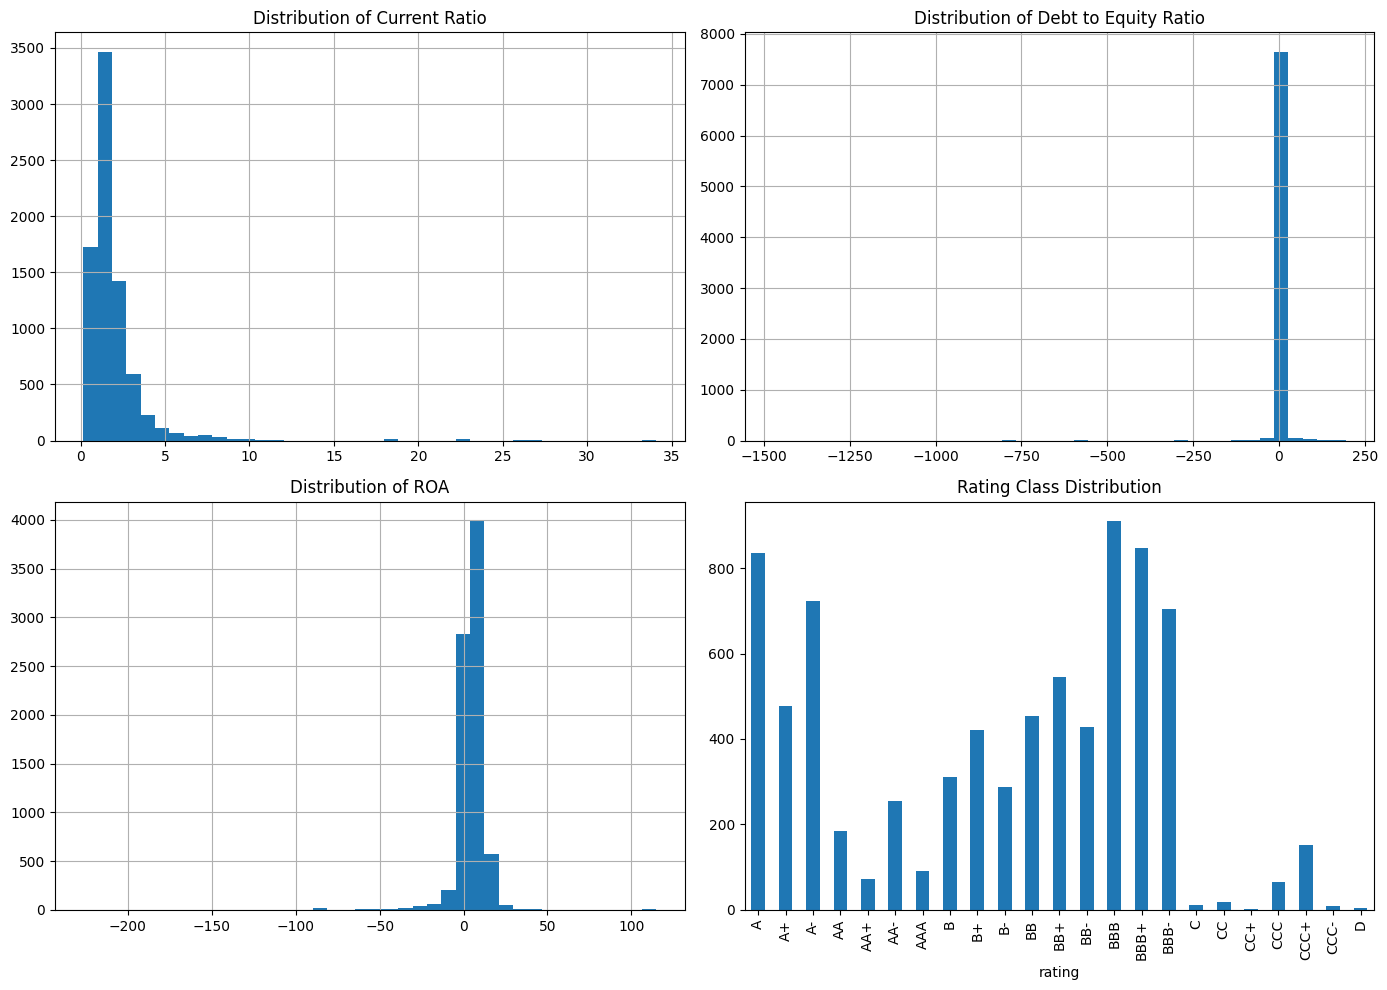

In [24]:
visual_code_writer = student_a

import matplotlib.pyplot as plt

start_time_vis = now()

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

if "current_ratio" in data.columns:
    data["current_ratio"].hist(ax=axs[0, 0], bins=40)
    axs[0, 0].set_title("Distribution of Current Ratio")

if "debt_equity_ratio" in data.columns:
    data["debt_equity_ratio"].hist(ax=axs[0, 1], bins=40)
    axs[0, 1].set_title("Distribution of Debt to Equity Ratio")

if "roa___return_on_assets" in data.columns:
    data["roa___return_on_assets"].hist(ax=axs[1, 0], bins=40)
    axs[1, 0].set_title("Distribution of ROA")

if "rating" in data.columns:
    data["rating"].value_counts().sort_index().plot(kind="bar", ax=axs[1, 1])
    axs[1, 1].set_title("Rating Class Distribution")

plt.tight_layout()
plt.show()

end_time_vis = now()

#############################################
# Documentation
#############################################

visual_comment = """
Produce histograms for selected financial ratios and a bar chart for rating classes.
The plots show skewed distributions, long tails, and strong class imbalance.
These observations support later decisions on outlier handling, transformation,
and class weighting strategies.
"""

vis_ass_uuid_executor = "bbeb7ab9-c9f1-4b99-a248-212b9bfc7ae7"
visual_executor_triples = [
    f':visual_exploration prov:qualifiedAssociation :{vis_ass_uuid_executor} .',
    f':{vis_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{vis_ass_uuid_executor} rdf:type prov:Association .',
    f':{vis_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(visual_executor_triples, prefixes=prefixes)

vis_ass_uuid_writer = "64c6a0ef-5ce3-4ad0-9efb-342b5a03c900"
visual_activity = [
    ':visual_exploration rdf:type prov:Activity .',
    ':visual_exploration sc:isPartOf :data_understanding_phase .',
    ':visual_exploration rdfs:comment \'Data Understanding\' .',
    f':visual_exploration rdfs:comment """{visual_comment}""" .',
    f':visual_exploration prov:startedAtTime "{start_time_vis}"^^xsd:dateTime .',
    f':visual_exploration prov:endedAtTime "{end_time_vis}"^^xsd:dateTime .',
    ':visual_exploration prov:used :data .',
    f':visual_exploration prov:qualifiedAssociation :{vis_ass_uuid_writer} .',
    f':{vis_ass_uuid_writer} prov:agent :{visual_code_writer} .',
    f':{vis_ass_uuid_writer} rdf:type prov:Association .',
    f':{vis_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':visual_exploration_report rdf:type prov:Entity .',
    ':visual_exploration_report rdfs:label "Visual Exploration Summary" .',
    ':visual_exploration_report rdfs:comment """Histograms for key ratios and rating distribution plotted for data understanding.""" .',
    ':visual_exploration_report prov:wasGeneratedBy :visual_exploration .',
]
engine.insert(visual_activity, prefixes=prefixes)

## 2e) Sensitive attributes and minority groups

In [25]:
sensitive_code_writer = student_a

sensitive_comment = """
The dataset does not contain explicit sensitive attributes such as gender or ethnicity. Minority groups appear in rare target classes, especially rating classes 0 and 1. These classes have few observations and need attention in evaluation and model design, for example through class weights or sampling strategies.
"""

start_time_sens = now()
end_time_sens = now()

sensitive_ass_uuid_executor = "eee58b3c-59ac-4f30-be56-e51564c13b29"
sensitive_executor_triples = [
    f':document_sensitive_attributes prov:qualifiedAssociation :{sensitive_ass_uuid_executor} .',
    f':{sensitive_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{sensitive_ass_uuid_executor} rdf:type prov:Association .',
    f':{sensitive_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(sensitive_executor_triples, prefixes=prefixes)

sensitive_ass_uuid_writer = "04896b6f-8691-498d-ab9d-08a0a5248604"
sensitive_activity = [
    ':document_sensitive_attributes rdf:type prov:Activity .',
    ':document_sensitive_attributes sc:isPartOf :data_understanding_phase .',
    ':document_sensitive_attributes rdfs:comment \'Data Understanding\' .',
    f':document_sensitive_attributes rdfs:comment """{sensitive_comment}""" .',
    f':document_sensitive_attributes prov:startedAtTime "{start_time_sens}"^^xsd:dateTime .',
    f':document_sensitive_attributes prov:endedAtTime "{end_time_sens}"^^xsd:dateTime .',
    f':document_sensitive_attributes prov:qualifiedAssociation :{sensitive_ass_uuid_writer} .',
    f':{sensitive_ass_uuid_writer} prov:agent :{sensitive_code_writer} .',
    f':{sensitive_ass_uuid_writer} rdf:type prov:Association .',
    f':{sensitive_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':sensitive_attributes_report rdf:type prov:Entity .',
    ':sensitive_attributes_report rdfs:label "2e Sensitive Attributes and Minority Groups" .',
    f':sensitive_attributes_report rdfs:comment """{sensitive_comment}""" .',
    ':sensitive_attributes_report prov:wasGeneratedBy :document_sensitive_attributes .',
]
engine.insert(sensitive_activity, prefixes=prefixes)


## 2f) Risks and bias in the data

In [29]:
bias_code_writer = student_a

bias_comment = """
Historical ratings reflect past human judgment and internal policies. This creates systematic bias in the target labels. Missing sector information hides structural differences between industries and firm sizes.

rating_date spans multiple years, so changes in the economic cycle and internal rating guidelines influence label stability and calibration.

Open questions for a domain expert:
1) Did rating guidelines change during the covered period.
2) Are some industries overrepresented in the dataset.
3) Are financial ratios comparable across firm sizes for all rating classes.
"""

start_time_bias = now()
end_time_bias = now()

bias_ass_uuid_executor = "46aa277a-34f3-4eba-86b3-f167be971cad"
bias_executor_triples = [
    f':document_bias_risks prov:qualifiedAssociation :{bias_ass_uuid_executor} .',
    f':{bias_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{bias_ass_uuid_executor} rdf:type prov:Association .',
    f':{bias_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(bias_executor_triples, prefixes=prefixes)

bias_ass_uuid_writer = "881a1f63-3710-48a8-ac0a-61a5f9bf5869"
bias_activity = [
    ':document_bias_risks rdf:type prov:Activity .',
    ':document_bias_risks sc:isPartOf :data_understanding_phase .',
    ':document_bias_risks rdfs:comment \'Data Understanding\' .',
    f':document_bias_risks rdfs:comment """{bias_comment}""" .',
    f':document_bias_risks prov:startedAtTime "{start_time_bias}"^^xsd:dateTime .',
    f':document_bias_risks prov:endedAtTime "{end_time_bias}"^^xsd:dateTime .',
    f':document_bias_risks prov:qualifiedAssociation :{bias_ass_uuid_writer} .',
    f':{bias_ass_uuid_writer} prov:agent :{bias_code_writer} .',
    f':{bias_ass_uuid_writer} rdf:type prov:Association .',
    f':{bias_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':bias_risks_report rdf:type prov:Entity .',
    ':bias_risks_report rdfs:label "2f Risks and Bias in Data" .',
    f':bias_risks_report rdfs:comment """{bias_comment}""" .',
    ':bias_risks_report prov:wasGeneratedBy :document_bias_risks .',
]
engine.insert(bias_activity, prefixes=prefixes)


## 2g) Planned actions for data preparation

In [28]:
prep_code_writer = student_a

prep_comment = """
Planned preparation actions based on the data understanding findings:

1) Cap extreme outliers in leverage, liquidity, and profitability ratios instead of dropping rows, to keep more observations.
2) Apply suitable strategies for missing values, for example dropping rows with many missing entries and imputing single missing ratios.
3) Encode rating as ordinal target and keep binary_rating as helper target for alternative evaluation.
4) Address class imbalance with stratified splits and class weights during model training.
5) Normalize or transform strongly skewed ratios, for example with log transforms for strictly positive variables.
"""

start_time_prep = now()
end_time_prep = now()

prep_ass_uuid_executor = "beeb3651-2154-48d7-b616-1f040c8deb56"
prep_executor_triples = [
    f':document_preparation_actions prov:qualifiedAssociation :{prep_ass_uuid_executor} .',
    f':{prep_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{prep_ass_uuid_executor} rdf:type prov:Association .',
    f':{prep_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(prep_executor_triples, prefixes=prefixes)

prep_ass_uuid_writer = "bfc079c5-0dbe-477c-b1cd-56f85f8dcbf8"
prep_activity = [
    ':document_preparation_actions rdf:type prov:Activity .',
    ':document_preparation_actions sc:isPartOf :data_understanding_phase .',
    ':document_preparation_actions rdfs:comment \'Data Understanding\' .',
    f':document_preparation_actions rdfs:comment """{prep_comment}""" .',
    f':document_preparation_actions prov:startedAtTime "{start_time_prep}"^^xsd:dateTime .',
    f':document_preparation_actions prov:endedAtTime "{end_time_prep}"^^xsd:dateTime .',
    f':document_preparation_actions prov:qualifiedAssociation :{prep_ass_uuid_writer} .',
    f':{prep_ass_uuid_writer} prov:agent :{prep_code_writer} .',
    f':{prep_ass_uuid_writer} rdf:type prov:Association .',
    f':{prep_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':preparation_actions_report rdf:type prov:Entity .',
    ':preparation_actions_report rdfs:label "2g Planned Data Preparation Actions" .',
    f':preparation_actions_report rdfs:comment """{prep_comment}""" .',
    ':preparation_actions_report prov:wasGeneratedBy :document_preparation_actions .',
]
engine.insert(prep_activity, prefixes=prefixes)


## Data Preparation

In [65]:
## Each Activity that follows is part of the Data Preparation Phase

data_preparation_phase_executor = [
f':data_preparation_phase rdf:type prov:Activity .',
f':data_preparation_phase rdfs:label "Data Preparation Phase" .', 
]
engine.insert(data_preparation_phase_executor, prefixes=prefixes)

In [66]:
handle_outliers_code_writer = student_b
def handle_outliers(df:pd.DataFrame, outliers_report: dict) -> pd.DataFrame:
    # REMOVE OUTLIERS
    return df

start_time_td = now()
handle_outliers(data, outliers_report)
end_time_td = now()

#############################################
# Documentation
#############################################
# This is the continuation of the example from the Data Understanding phase above.
# There are three steps involved in this process:
# 1. activity creates a figure, report etc. => already done in data understanding phase
# 2. activity inspects the outcome and derives decisions => already done in data understanding phase
# 3. activity follows up on the decision by changing the data => in this case by removing the the outliers that were found

ro_ass_uuid_executor = "ec7e81e1-86ea-475a-a8d4-c7d8ee535488"
handle_outliers_executor = [
    f':handle_outliers prov:qualifiedAssociation :{ro_ass_uuid_executor} .',
    f':{ro_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ro_ass_uuid_executor} rdf:type prov:Association .',
    f':{ro_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(handle_outliers_executor, prefixes=prefixes)

td_ass_uuid_writer = "1405f15a-3545-4014-a962-637f3c10a137"
td_comment = """
Removing all outliers that were identifying in the Data Understanding Phase.
"""
handle_outliers_activity = [
    ':handle_outliers rdf:type prov:Activity .',
    ':handle_outliers sc:isPartOf :data_preparation_phase .',
    ':handle_outliers rdfs:comment \'Data Preparation\' .', 
    f':handle_outliers rdfs:comment """{td_comment}""" .', 
    f':handle_outliers prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{handle_outliers_code_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_outliers prov:used :data .',
    ':handle_outliers prov:used :outlier_decision .',
    ':cleaned_data rdf:type prov:Entity .',
    ':cleaned_data prov:wasGeneratedBy :handle_outliers .',
    ':cleaned_data prov:wasDerivedFrom :data .',
]
engine.insert(handle_outliers_activity, prefixes=prefixes)

**Continue with other tasks of the Data Preparation phase such as binning, scaling etc...**

In [67]:
# Your final transformed dataset should also be documented appropriately using Croissant, SI, etc.

prepared_data_triples = [
    ':prepared_data rdf:type prov:Entity .',
    ':prepared_data prov:wasDerivedFrom :cleaned_data .',
    ':prepared_data rdf:type sc:Dataset .',
    # ....
]
engine.insert(prepared_data_triples, prefixes=prefixes)

## Modeling

In [68]:
## Each Activity that follows is part of the Modeling Phase

modeling_phase_executor = [
f':modeling_phase rdf:type prov:Activity .',
f':modeling rdfs:label "Modeling Phase" .', 
]
engine.insert(modeling_phase_executor, prefixes=prefixes)


In [69]:
model_data_code_writer = student_a

#############################################
# Documentation 4a
#############################################

dma_ass_uuid_writer = "b3e840ab-ac23-415e-bd9c-6d00bb79c37a"
dma_comment = """
...
"""

identify_data_mining_algorithm_activity = [
    f':define_algorithm rdf:type prov:Activity .',
    f':define_algorithm sc:isPartOf :modeling_phase .',
    f':define_algorithm rdfs:comment """{dma_comment}""" .',
    f':define_algorithm prov:qualifiedAssociation :{dma_ass_uuid_writer} .',
    f':{dma_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{dma_ass_uuid_writer} rdf:type prov:Association .',
    f':{dma_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # example algorithm definition
    f':random_forest_algorithm rdf:type mls:Algorithm .',
    f':random_forest_algorithm rdfs:label "Random Forest Algorithm" .',

    # example implementation
    f':random_forrest_classifier_implementation rdf:type mls:Implementation .',
    f':random_forrest_classifier_implementation rdfs:label "Scikit-learn RandomForestClassifier" .',
    f':random_forrest_classifier_implementation mls:implements :random_forest_algorithm .',
    f':random_forrest_classifier_implementation prov:wasGeneratedBy :define_algorithm .',

    
    # you can also define your Evaluation Measures here
    
    # example evaluation 
    f':r2_score_measure rdf:type mls:EvaluationMeasure .',
    f':r2_score_measure rdfs:label "R-squared Score" .',
    f':r2_score_measure rdfs:comment "xxx" .',
    f':r2_score_measure prov:wasGeneratedBy :define_algorithm .',

    
]
engine.insert(identify_data_mining_algorithm_activity, prefixes=prefixes)

In [70]:
#############################################
# Documentation 4b
#############################################

hp_ass_uuid_writer = "fff582a8-c5cd-4030-978b-9f56b603167c"
hp_comment = """
...
"""
identify_hp_activity = [
    f':identify_hyperparameters rdf:type prov:Activity .',
    f':identify_hyperparameters sc:isPartOf :modeling_phase .',
    f':identify_hyperparameters rdfs:comment """{hp_comment}""" .',
    f':identify_hyperparameters prov:qualifiedAssociation :{hp_ass_uuid_writer} .',
    f':{hp_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{hp_ass_uuid_writer} rdf:type prov:Association .',
    f':{hp_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # example parameter
    f':hp_learning_rate rdf:type mls:HyperParameter .',
    f':hp_learning_rate rdfs:label "Learning Rate" .',
    f':hp_learning_rate rdfs:comment "..." .',
    f':random_forrest_classifier_implementation mls:hasHyperParameter :hp_learning_rate .',
    f':hp_learning_rate prov:wasGeneratedBy :identify_hyperparameters .',

    # continue with your identified hyperparameters
    
]
engine.insert(identify_hp_activity, prefixes=prefixes)

In [71]:
def split_data(df: pd.DataFrame):
    #do something
    return 'train_set', 'validation_set', 'test_set'

#############################################
# Documentation 4c
#############################################

### Define Train/Validation/Test splits
split_ass_uuid_writer = "fb58ae6c-9d58-44c9-ac7e-529111bdf7fc"
split_comment = """
...
"""
## Use your prepared dataset
input_dataset = ":prepared_data" 

define_split_activity = [
    f':define_data_split rdf:type prov:Activity .',
    f':define_data_split sc:isPartOf :modeling_phase .',
    f':define_data_split rdfs:comment "Train/Validation/Test Split Definition" .',
    f':define_data_split rdfs:comment """{split_comment}""" .',
    f':define_data_split prov:qualifiedAssociation :{split_ass_uuid_writer} .',
    f':{split_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{split_ass_uuid_writer} rdf:type prov:Association .',
    f':{split_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    f':define_data_split prov:used {input_dataset} .',
    
    # Training Set
    f':training_set rdf:type sc:Dataset .',
    f':training_set rdfs:label "Training Set" .',
    f':training_set prov:wasGeneratedBy :define_data_split .',
    f':training_set prov:wasDerivedFrom {input_dataset} .',
    f':training_set rdfs:comment "Contains xx samples" .', 

    # Validation Set
    f':validation_set rdf:type sc:Dataset .',
    f':validation_set rdfs:label "Validation Set" .',
    f':validation_set prov:wasGeneratedBy :define_data_split .',
    f':validation_set prov:wasDerivedFrom {input_dataset} .',
    f':validation_set rdfs:comment "Contains xx samples" .', 

    # Test Set
    f':test_set rdf:type sc:Dataset .',
    f':test_set rdfs:label "Test Set" .',
    f':test_set prov:wasGeneratedBy :define_data_split .',
    f':test_set prov:wasDerivedFrom {input_dataset} .',
    f':test_set rdfs:comment "Contains xx samples" .', 

    
]
engine.insert(define_split_activity, prefixes=prefixes)

In [72]:
def train_and_finetune_model(training_set, validation_set):
    # do something here

    # Try to automate as much documentation work as possible.
    # Define your training runs with their respective hyperparameter settings, etc.
    # Document each time a training run, model, its hp_settings, evaluations, ...  
    # Create performance figures/graphs

    return 'Find most suitable model'


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now() 


#############################################
# Documentation 4d & e & f
#############################################

tafm_ass_uuid_writer = "21d60fe3-c9ab-4a0a-bae7-b9fe9653c755"
tafm_comment = """
...
"""

# EXAMPLE output from your training
training_run1 = "run_1" 
model_run1 = "model_run1"
hp1_setting_run1 = "hp_setting_run1"
eval_train_run1 = "metric_train_run1"
eval_validation_run1 = "metric_validation_run1"


train_model_activity = [
    # Activity 
    f':train_and_finetune_model rdf:type prov:Activity .',
    f':train_and_finetune_model sc:isPartOf :modeling_phase .',
    f':train_and_finetune_model rdfs:comment """{tafm_comment}""" .',
    f':train_and_finetune_model prov:startedAtTime "{start_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:endedAtTime "{end_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:qualifiedAssociation :{tafm_ass_uuid_writer} .',
    f':{tafm_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{tafm_ass_uuid_writer} rdf:type prov:Association .',
    f':{tafm_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    ########################################
    # ONE model run - automate everything below!

    # Parameter settings
    f':{hp1_setting_run1} rdf:type mls:HyperParameterSetting .',
    f':{hp1_setting_run1} mls:specifiedBy :hp_learning_rate .',
    f':{hp1_setting_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{hp1_setting_run1} prov:wasGeneratedBy :train_and_finetune_model .',
    # add your further parameters

    # Describe your Run
    f':{training_run1} rdf:type mls:Run .',
    f':{training_run1} sc:isPartOf :train_and_finetune_model .',
    f':{training_run1} mls:realizes :random_forest_algorithm .',
    f':{training_run1} rdf:label "Training Run 1 with..." .',
    f':{training_run1} mls:executes :your_implementation .', 
    f':{training_run1} mls:hasInput :training_set .',
    f':{training_run1} mls:hasInput :validation_set .',
    f':{training_run1} mls:hasInput :{hp1_setting_run1} .',     
    # list all your used parameters here
    f':{training_run1} mls:hasOutput :{model_run1} .',
    f':{training_run1} mls:hasOutput :{eval_train_run1} .',
    f':{training_run1} mls:hasOutput :{eval_validation_run1} .',

    # Describe your Model
    f':{model_run1} rdf:type mls:Model .',
    f':{model_run1} prov:label "xxx" .',
    f':{model_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{model_run1} mlso:trainedOn :training_set .',
    f':{model_run1} mlso:hasAlgorithmType :random_forest_algorithm .',

    # Describe your evaluations
    # You can have multiple evaluations per model 
    f':{eval_train_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_train_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_train_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_train_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_train_run1} prov:used :training_set .',

    f':{eval_validation_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_validation_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_validation_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_validation_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_validation_run1} prov:used :validation_set .',

    # Dont forget to document any visualizations

]
engine.insert(train_model_activity, prefixes=prefixes)


In [73]:
def retrain_model_full_data(training_set, validation_set):
    
    # create your
    return "Final Trained Model"


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now() 


#############################################
# Documentation 4g
#############################################

retrain_ass_uuid_writer = "96815ee0-524c-437b-b5fa-2e15b945c993" # Generate once

final_training_activity = ":retrain_final_model"
final_model = ":final_model_entity"

# Document the retraining activity.
# Hint: This activity is still part of the :modeling_phase

retrain_documentation = [
    # your documentation here    
]
engine.insert(retrain_documentation, prefixes=prefixes)


## Evaluation

In [74]:
## Each Activity that follows is part of the Evaluation Phase

evaluation_phase_executor = [
f':evaluation_phase rdf:type prov:Activity .',
f':evaluation_phase rdfs:label "Evaluation Phase" .', 
]
engine.insert(evaluation_phase_executor, prefixes=prefixes)

In [75]:
eval_code_writer = student_b
def evaluate_on_test_data(final_model, test_set):

    # Predict and evaluation on test data
        
    return 'Performance'

start_time_eval = now()
#evaluate_on_test_data()
end_time_eval = now() 

#############################################
# Documentation
#############################################

eval_ass_uuid = "7f1431e9-feed-429a-92ed-c131b23cbe79" # Generate once
final_model = ":final_model_entity" 
test_set = ":test_set" 

eval_comment = """
...
"""

evaluate_activity = [
    f':evaluate_final_model rdf:type prov:Activity .',
    f':evaluate_final_model sc:isPartOf :evaluation_phase .',
    f':evaluate_final_model rdfs:label "Final Model Evaluation on Test Set" .',
    f':evaluate_final_model rdfs:comment """{eval_comment}""" .',
    f':evaluate_final_model prov:startedAtTime "{start_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:endedAtTime "{end_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:qualifiedAssociation :{eval_ass_uuid} .',
    
    f':{eval_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{eval_ass_uuid} rdf:type prov:Association .',
    f':{eval_ass_uuid} prov:hadRole :{code_writer_role} .',

    # Inputs
    f':evaluate_final_model prov:used {final_model} .',
    f':evaluate_final_model prov:used {test_set} .',
    
    # Reference to Data Mining Success Criteria from Phase 1
    f':evaluate_final_model prov:used :bu_data_mining_success_criteria .',

    # Document you final model performance
 
    # Hint: you evaluate bias in this way:
    f':bias_evaluation_result rdf:type mls:ModelEvaluation .',
    f':bias_evaluation_result prov:wasGeneratedBy :evaluate_final_model .',
    f':bias_evaluation_result rdfs:label "Bias Analysis" .',
    f':bias_evaluation_result rdfs:comment "..." .',
    
]
engine.insert(evaluate_activity, prefixes=prefixes)

## Deployment

In [76]:
## Each Activity that follows is part of the Deployment Phase

deployment_phase_executor = [
f':deployment_phase rdf:type prov:Activity .',
f':deployment_phase rdfs:label "Deployment Phase" .', 
]
engine.insert(deployment_phase_executor, prefixes=prefixes)

In [77]:
#############################################
# Documentation
#############################################

comparison_and_recommendations_comment = """
...
"""

ethical_aspects_comment = """
...
"""

monitoring_plan_comment = """
...
"""

reproducibility_reflection_comment = """
...
"""

dep_ass_uuid_executor = "72a921e0-1234-4567-89ab-cdef01234567" # Generate once
deployment_executor = [
f':plan_deployment rdf:type prov:Activity .',
f':plan_deployment sc:isPartOf :deployment_phase .', # Connect to Parent Phase
f':plan_deployment rdfs:label "Plan Deployment"@en .',

f':plan_deployment prov:qualifiedAssociation :{dep_ass_uuid_executor} .',
f':{dep_ass_uuid_executor} prov:agent :{executed_by} .',
f':{dep_ass_uuid_executor} rdf:type prov:Association .',
f':{dep_ass_uuid_executor} prov:hadRole :{code_executor_role} .', 
]
engine.insert(deployment_executor, prefixes=prefixes)


deployment_data_executor = [
#6a
f':dep_recommendations rdf:type prov:Entity .',
f':dep_recommendations prov:wasGeneratedBy :plan_deployment .',
f':dep_recommendations rdfs:label "6a Business Objectives Reflection and Deployment Recommendations" .',
f':dep_recommendations rdfs:comment """{comparison_and_recommendations_comment}""" .',
#6b
f':dep_ethical_risks rdf:type prov:Entity .',
f':dep_ethical_risks prov:wasGeneratedBy :plan_deployment .',
f':dep_ethical_risks rdfs:label "6b Ethical Aspects and Risks" .',
f':dep_ethical_risks rdfs:comment """{ethical_aspects_comment}""" .',
#6c
f':dep_monitoring_plan rdf:type prov:Entity .',
f':dep_monitoring_plan prov:wasGeneratedBy :plan_deployment .',
f':dep_monitoring_plan rdfs:label "6c Monitoring Plan" .',
f':dep_monitoring_plan rdfs:comment """{monitoring_plan_comment}""" .',
#6d
f':dep_reproducibility_reflection rdf:type prov:Entity .',
f':dep_reproducibility_reflection prov:wasGeneratedBy :plan_deployment .',
f':dep_reproducibility_reflection rdfs:label "6d Reproducibility Reflection" .',
f':dep_reproducibility_reflection rdfs:comment """{reproducibility_reflection_comment}""" .',

]
engine.insert(deployment_data_executor, prefixes=prefixes)

# Generate Latex Report

The following cells give you an example of how to automatically create a Latex Report from your provenance documentation.

Feel free to use the example provided. If you use it, you should adapt and extend it with relevant sections/tables/plots/... 

In [38]:
base_iri = f"https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/"

In [39]:
# This cell includes cleaning functions

from datetime import datetime

def latex_escape(text: str | None) -> str:
    if text is None: return ""
    text = str(text)
    text = text.replace("\\", r"\textbackslash{}")
    pairs = [
        ("&", r"\&"), ("%", r"\%"), ("$", r"\$"), ("#", r"\#"), 
        ("_", r"\_"), ("{", r"\{"), ("}", r"\}"), 
        ("~", r"\textasciitilde{}"), ("^", r"\textasciicircum{}")
    ]
    for k, v in pairs:
        text = text.replace(k, v)
    return text

def clean_rdf(x) -> str:
    if hasattr(x, "toPython"): return str(x.toPython())
    if x is None: return ""
    s = str(x).strip()
    s = s.strip('"').strip("'")
    s = s.strip()
    if "^^" in s:
        s = s.split("^^")[0].strip('"')
        
    return s

def fmt_iso(ts: str) -> str:
    if not ts: return ""
    try:
        clean_ts = ts.split("^^")[0].strip('"')
        clean_ts = clean_ts.replace("Z", "+00:00") if clean_ts.endswith("Z") else clean_ts
        return datetime.fromisoformat(clean_ts).strftime("%Y-%m-%d %H:%M:%S")
    except:
        return latex_escape(str(ts))

In [44]:
# This cell includes exemplary queries for different phases


### Author Block
author_query = f"""
{prefix_header}
PREFIX iao: <http://purl.obolibrary.org/obo/>

SELECT DISTINCT ?uri ?given ?family ?matr WHERE {{
  VALUES ?uri {{ :{student_a} :{student_b} }}
  
  ?uri a foaf:Person .
  ?uri foaf:givenName ?given .
  ?uri foaf:familyName ?family .
  ?uri iao:IAO_0000219 ?matr .
}}
"""

res_authors = engine.query(author_query, yn_timestamp_query=False)
author_block_latex = ""

if not res_authors.empty: # type:ignore
    for _, row in res_authors.iterrows(): # type:ignore

        uri_str = str(row['uri'])
        given = latex_escape(clean_rdf(row['given']))
        family = latex_escape(clean_rdf(row['family']))
        matr = latex_escape(clean_rdf(row['matr']))
        if student_a in uri_str:
            responsibility = "Student A"
        elif student_b in uri_str:
            responsibility = "Student B"
        else:
            responsibility = "Student"
        
        author_block_latex += rf"""
          \author{{{given} {family}}}
          \authornote{{{responsibility}, Matr.Nr.: {matr}}}
          \affiliation{{
            \institution{{TU Wien}}
            \country{{Austria}}
          }}
          """

### Business Understanding example
bu_query = f"""
{prefix_header}

SELECT ?ds_comment ?bo_comment WHERE {{
  OPTIONAL {{ :bu_data_source_and_scenario rdfs:comment ?ds_comment . }}
  OPTIONAL {{ :bu_business_objectives rdfs:comment ?bo_comment . }}
}} LIMIT 1
"""
res_bu = engine.query(bu_query, yn_timestamp_query=False)
row_bu = res_bu.iloc[0] if not res_bu.empty else {} # type:ignore
bu_data_source = latex_escape(clean_rdf(row_bu.get("ds_comment", "")))
bu_objectives  = latex_escape(clean_rdf(row_bu.get("bo_comment", "")))


### Data Understanding examples
# Example Dataset Description
du_desc_query = f"""
{prefix_header}
SELECT ?desc WHERE {{ :raw_data sc:description ?desc . }} LIMIT 1
"""
res_du_desc = engine.query(du_desc_query,  yn_timestamp_query=False)
row_du_desc = res_du_desc.iloc[0] if not res_du_desc.empty else {} # type:ignore
du_description = latex_escape(clean_rdf(row_du_desc.get("desc", "")))

# Example Feature Columns Table
du_query = f"""
{prefix_header}

SELECT ?name (SAMPLE(?dtypeRaw) as ?dtype) (SAMPLE(?descRaw) as ?desc) WHERE {{
  :raw_data cr:recordSet ?rs .
  ?rs cr:field ?field .
  ?field sc:name ?name .
  ?field sc:description ?descRaw .
  ?field cr:dataType ?dtypeRaw .
}} 
GROUP BY ?name
ORDER BY ?name
"""
res_du = engine.query(du_query,  yn_timestamp_query=False)
du_rows = []
if not res_du.empty: # type:ignore
    for _, f in res_du.iterrows(): # type:ignore
        dtype_raw = clean_rdf(f.get("dtype", ""))
        if '#' in dtype_raw: dtype = dtype_raw.split('#')[-1]
        elif '/' in dtype_raw: dtype = dtype_raw.split('/')[-1]
        else: dtype = dtype_raw
        
        desc = clean_rdf(f.get("desc", ""))
        row_str = f"{latex_escape(clean_rdf(f['name']))} & {latex_escape(dtype)} & {latex_escape(desc)} \\\\"
        du_rows.append(row_str)
du_table_rows = "\n    ".join(du_rows)

### Modeling example
# Hyperparameters
hp_query = f"""
{prefix_header}

SELECT ?hpName (SAMPLE(?hpValRaw) as ?hpVal) (MAX(?hpDescRaw) as ?hpDesc) WHERE {{
  ?run sc:isPartOf :train_and_finetune_model .
  ?run mls:hasInput ?setting .
  ?setting a mls:HyperParameterSetting .
  ?setting mls:hasValue ?hpValRaw .
  ?setting mls:specifiedBy ?hpDef .
  ?hpDef rdfs:label ?hpName .
  OPTIONAL {{ ?hpDef rdfs:comment ?hpDescRaw . }}
}} 
GROUP BY ?hpName
ORDER BY ?hpName
"""
res_hp = engine.query(hp_query,  yn_timestamp_query=False)
hp_rows = []
if not res_hp.empty: #type:ignore
    for _, row in res_hp.iterrows(): #type:ignore
        name = latex_escape(clean_rdf(row['hpName']))
        val  = latex_escape(clean_rdf(row['hpVal']))
        desc = latex_escape(clean_rdf(row.get('hpDesc', '')))
        hp_rows.append(rf"{name} & {desc} & {val} \\")

hp_table_rows = "\n    ".join(hp_rows)

# Run Info
run_query = f"""
{prefix_header}

SELECT ?algoLabel ?start ?end ?metricLabel ?metricVal WHERE {{
  OPTIONAL {{ :train_and_finetune_model prov:startedAtTime ?start ; prov:endedAtTime ?end . }}
  OPTIONAL {{
      ?run sc:isPartOf :train_and_finetune_model .
      ?run mls:realizes ?algo .
      ?algo rdfs:label ?algoLabel .
  }}
  OPTIONAL {{
    ?run sc:isPartOf :train_and_finetune_model .
    ?run mls:hasOutput ?eval .
    ?eval a mls:ModelEvaluation ; mls:hasValue ?metricVal .
    OPTIONAL {{ ?eval mls:specifiedBy ?m . ?m rdfs:label ?metricLabel . }}
  }}
}} LIMIT 1
"""
res_run = engine.query(run_query,  yn_timestamp_query=False)
row_run = res_run.iloc[0] if not res_run.empty else {} #type:ignore
mod_algo  = latex_escape(clean_rdf(row_run.get("algoLabel", "")))
mod_start = latex_escape(fmt_iso(clean_rdf(row_run.get("start"))))
mod_end   = latex_escape(fmt_iso(clean_rdf(row_run.get("end"))))
mod_m_lbl = latex_escape(clean_rdf(row_run.get("metricLabel", "")))
raw_val = clean_rdf(row_run.get('metricVal', ''))
mod_m_val = f"{float(raw_val):.4f}" if raw_val else ""

print("Data extraction done.")

Data extraction done.


The following includes the Latex report itself. It fills in the query-results from the cell before. The ACM Template is already filled. 
Make sure that you update Student A and B accordingly.

In [45]:
latex_content = rf"""\documentclass[sigconf]{{acmart}}

\AtBeginDocument{{ \providecommand\BibTeX{{ Bib\TeX }} }}
\setcopyright{{acmlicensed}}
\copyrightyear{{2025}}
\acmYear{{2025}}
\acmDOI{{XXXXXXX.XXXXXXX}}

\acmConference[BI 2025]{{Business Intelligence}}{{-}}{{-}}

\begin{{document}}

\title{{BI2025 Experiment Report - Group {group_id}}}
%% ---Authors: Dynamically added ---
{author_block_latex}

\begin{{abstract}}
  This report documents the machine learning experiment for Group {group_id}, following the CRISP-DM process model.
\end{{abstract}}

\ccsdesc[500]{{Computing methodologies~Machine learning}}
\keywords{{CRISP-DM, Provenance, Knowledge Graph, Machine Learning}}

\maketitle

%% --- 1. Business Understanding ---
\section{{Business Understanding}}

\subsection{{Data Source and Scenario}}
{bu_data_source}

\subsection{{Business Objectives}}
{bu_objectives}

%% --- 2. Data Understanding ---
\section{{Data Understanding}}
\textbf{{Dataset Description:}} {du_description}

The following features were identified in the dataset:

\begin{{table}}[h]
  \caption{{Raw Data Features}}
  \label{{tab:features}}
  \begin{{tabular}}{{lp{{0.2\linewidth}}p{{0.4\linewidth}}}}
    \toprule
    \textbf{{Feature Name}} & \textbf{{Data Type}} & \textbf{{Description}} \\
    \midrule
    {du_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

%% --- 3. Data Preparation ---
\section{{Data Preparation}}
\subsection{{Data Cleaning}}
Describe your Data preparation steps here and include respective graph data.


%% --- 4. Modeling ---
\section{{Modeling}}

\subsection{{Hyperparameter Configuration}}
The model was trained using the following hyperparameter settings:

\begin{{table}}[h]
  \caption{{Hyperparameter Settings}}
  \label{{tab:hyperparams}}
  \begin{{tabular}}{{lp{{0.4\linewidth}}l}}
    \toprule
    \textbf{{Parameter}} & \textbf{{Description}} & \textbf{{Value}} \\
    \midrule
    {hp_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

\subsection{{Training Run}}
A training run was executed with the following characteristics:
\begin{{itemize}}
    \item \textbf{{Algorithm:}} {mod_algo}
    \item \textbf{{Start Time:}} {mod_start}
    \item \textbf{{End Time:}} {mod_end}
    \item \textbf{{Result:}} {mod_m_lbl} = {mod_m_val}
\end{{itemize}}

%% --- 5. Evaluation ---
\section{{Evaluation}}

%% --- 6. Deployment ---
\section{{Deployment}}

\section{{Conclusion}}

\end{{document}}
"""

In [43]:
# This cell stores the Latex report to the data/report directory

out_dir = os.path.join("data", "report")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "experiment_report.tex")

with open(out_path, "w", encoding="utf-8") as f:
    f.write(latex_content)

print(f"Report written to: {out_path}")

Report written to: data\report\experiment_report.tex


In [ ]:
query = f"""
{prefix_header}
SELECT ?s ?p ?o
WHERE {{
  ?s ?p ?o .
}}
LIMIT 100
"""

res = engine.query(query, yn_timestamp_query=False)
print(res)  # zeigt eine schöne Tabelle in Jupyter

